# NIH Chest X-ray Dataset:  https://www.kaggle.com/nih-chest-xrays/data

In [25]:
!ls ../input/ranzcr-chestxray-trainer-aug-640/resnet200d_320_fold0_eNx5.pth

../input/ranzcr-chestxray-trainer-aug-640/resnet200d_320_fold0_eNx5.pth


In [26]:
!cp ../input/ranzcr-chestxray-trainer-aug-640/resnet200d_320_fold0_eNx5.pth ./resnet200d_320_fold0_start.pth

In [27]:
import sys
sys.path.append('../input/pytorch-images-seresnet')

import os
import gc
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
import math

import fastai
from   fastai.callback.mixup import MixUp, CutMix
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.data.core import *
from   fastai.data.load import *
from   fastai.learner import Learner
from   fastai.metrics import *
from   fastai.optimizer import OptimWrapper 
from   fastai.losses import LabelSmoothingCrossEntropy

# from   warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold

import timm
import albumentations as A
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ("ignore")

In [28]:
class CFG:
    device       = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')
    num_workers  = 4
    model_name   = 'resnet200d_320' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    size         = 640  # [64, 128, 224, 384, 512, 640, 720]
    train        = True
    freeze       = True     # this is updated during training   
    epochs       = 1 
    epochsNx     = 1
    criterion    = "lovas"
    batch_size   = 118  #[10, 32, 64]
    lr           = 5e-4
    weight_decay = 1e-6
    max_grad_norm= 1000.0
    tta          = 3 
    seed         = 42
    target_size  = -1    # init below
    n_fold       = 100
    train_fold   = [0] #, 1, 2, 3, 4]
    # infer_fold = [0, 1, 2, 3, 4]
    img_ext      = '.png'
    img_col      = "Image Index"
    label_cols   = ["atelectasis", "consolidation", "infiltration", "pneumothorax", "edema", "emphysema", "fibrosis", "effusion", "pneumonia", "pleural_thickening", "cardiomegaly", "hernia", "nodule", "mass"]
    target_size  = len (label_cols)
    init_model_taget_sz = 11
    model_infer_path_prefix = "."    
    model_train_path_prefix = "."
    train_path   = '../input/data'
    train_csv    = '../input/data/Data_Entry_2017.csv'
    # test_path  = '../input/data'
    # test_csv   = '../input/data/test.csv'
    output_dir   = 'Output/'
    freeze_steps = 500         # after these steps, unfreeze model
    raw_label_cols = ['Finding Labels'] 

In [29]:
# df = pd.read_csv (CFG.train_csv)
# df.head()

In [30]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [31]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

## Preprocess train.csv

# Augmentation Dataset

In [32]:
def preprocess_train_csv ():
    
    classes = CFG.label_cols
    df = pd.read_csv (CFG.train_csv).reset_index (drop=True)
    cols = [CFG.img_col] + CFG.raw_label_cols
    df = df[cols]
    dg = df.groupby (CFG.img_col)
    df_dicts = []
    for k in dg:
        # print (k[0], list(k[1][CFG.raw_label_cols[0]]))
        row = {CFG.img_col:k[0]}
        for cat in classes:
            row[cat] = 0
        diseases = list (k[1][CFG.raw_label_cols[0]])
        diseases = [d.lower () for d in diseases]
        for disease in diseases:
            for cat in classes:
                if cat in disease:
                    row[cat] = 1
        df_dicts.append (row)
                
    df = pd.DataFrame.from_dict (df_dicts)
    # df.head ()
    return df

In [33]:
# df = preprocess_train_csv ()
# df.head ()

In [34]:
# NOTE: We don't normalize here since it all gets dark
# if advprop:           # for models using advprop pretrained weights
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
train_transforms = A.Compose ([
        A.HorizontalFlip (p=0.5),
        A.Resize (CFG.size, CFG.size),
        A.Normalize(),
        ToTensorV2 (p=1.0),
])
valid_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        A.Normalize(),
        ToTensorV2 (p=1.0),
])

def get_transforms (data='train'):
    
    if 'train' in data:
        return train_transforms
    elif 'valid' in data:
        return valid_transforms
    else:
        return valid_transforms

In [35]:
class ImgDataset (Datasets):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=CFG.label_cols,
                 transform=get_transforms(), img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super (ImgDataset, self).__init__(df.reset_index(drop=True), tfms=None, n_inp=1)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.items.shape[0]    
    
    def __getitem__(self, idx):
        
        file_path   = None
        file_name   = self.items[self.img_file_colname][idx].replace (self.img_ext, '') + self.img_ext
        img_folders = ['images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006', 'images_007', 'images_008', 'images_009', 'images_010', 'images_011', 'images_012']
        for img_folder in img_folders:
            file_path   = "{}/{}/images/{}".format (CFG.train_path, img_folder, file_name)
            if os.path.exists (file_path):
                break                                                   
        
        image = cv2.imread (file_path)
        image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform (image=image)['image'].float ()
        else:
            image = ToTensorV2 ()(image = image)["image"].float ()
            
        gc.collect()
        if len (self.label_cols) > 0:
            label = torch.tensor (self.items.loc[idx, self.label_cols]).float () # long ()
            return image, label
        return image

In [36]:
def getFolds ():
    
    train_folds_df = preprocess_train_csv ()   # pd.read_csv (CFG.train_csv)
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
        
    return train_folds_df

51

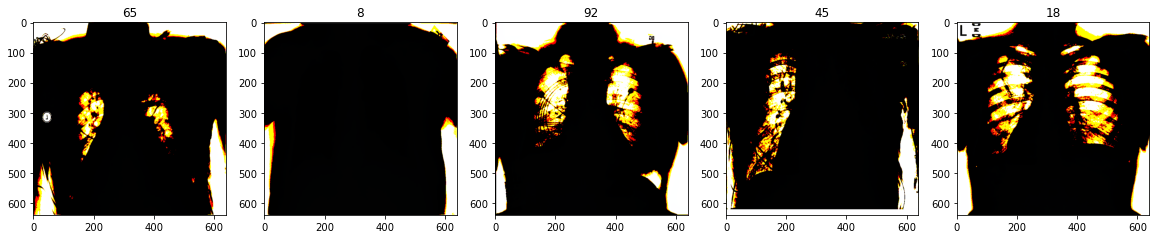

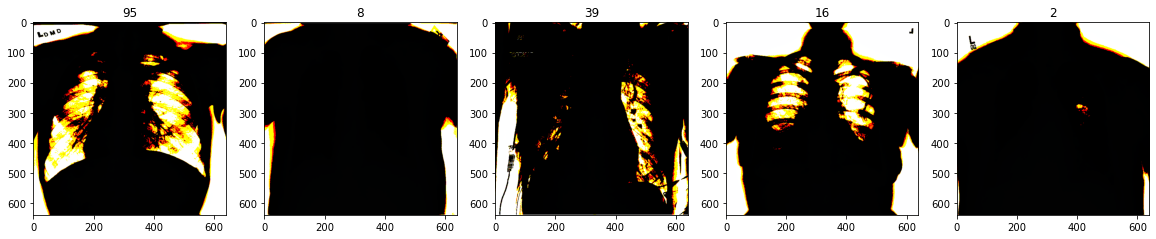

In [37]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                                    #;print (img.size())
            img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds ())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [51]:
from torch.autograd import Variable

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#=====
#Multi-class Lovasz loss
#=====

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
        inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz

In [52]:
def get_criterion (class_wt):
    
    criterion = LovaszHingeLoss ()
    return criterion

In [53]:
class ResNet200D_320(nn.Module):
    
    def __init__(self, model_name='resnet200d_320'):
        super().__init__()
        global CFG
        self.model = timm.create_model(model_name, pretrained=False)
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, CFG.init_model_taget_sz) #11
        CFG.n_features = n_features

    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.model.parameters ():
            param.requires_grad = False

        for param in self.fc.parameters ():
            param.requires_grad = True
        return
    
    def unfreeze (self):
        # Unfreeze all layers
        for param in self.model.parameters ():
            param.requires_grad = True
        for param in self.fc.parameters ():
            param.requires_grad = True
        return
    

class CustomResNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear (n_features, CFG.prev_target_size)
        return
    
    def forward(self, x):
        x = self.model (x)
        return x
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
            

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model (CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
    
    
class CustomDeiT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

    
class CustomViT(nn.Module):
    
    def __init__(self, model_name=CFG.model_name, pretrained=False):
                 # min_unfreez_layer=CFG.min_unfreez_layer, max_layer_no=CFG.max_layer_no):
        
        super().__init__()
        self.model      = timm.create_model(model_name, pretrained=pretrained)
        n_features      = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)
        self.min_unfreez_layer = min_unfreez_layer
        self.max_layer_no      = max_layer_no
        return

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
    # def unfreeze_layer (self, layer_no=11):
    #     # unfreeze a particular layer
    #     if layer_no >= self.min_unfreez_layer and layer_no <= self.max_layer_no:
    #         for param in self.model.blocks[layer_no].parameters ():
    #             param.requires_grad = False
    #     return

In [54]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates (subplots)
def plot_metrics (self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil (n / ncols))
    elif ncols is None: ncols = int(np.ceil (n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots (nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate (axs.flatten())][:n]
    for i, (name, ax) in enumerate (zip (names, [axs[0]] + axs)):
        ax.plot (metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title (name if i > 1 else 'losses')
        ax.legend (loc='best')
    plt.show ()

In [55]:
@delegates (torch.optim.AdamW.__init__)
def pytorch_AdamW (param_groups, **kwargs):
    return OptimWrapper (torch.optim.AdamW ([{'params': ps, **kwargs} for ps in param_groups]))

In [56]:
class UnfreezeCallback (Callback):
    
    def __init__(self, freeze_steps=CFG.freeze_steps):
        super().__init__()
        self.freeze_steps = freeze_steps
        return
        
    def after_batch (self):
        if self.iter == self.freeze_steps:
            print ('Unfreezing the model')
            self.learn.model.unfreeze ()

In [57]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))['model']
        # print (state_dict)
        model.load_state_dict (state_dict, strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [58]:
def getModel (fold, isTrain=True):
    
    model = None
    if CFG.model_name == 'resnet200d_320':
        model = ResNet200D_320 ()
    elif 'deit_' in CFG.model_name:
        model = CustomDeiT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'vit_' in CFG.model_name:
        model = CustomViT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'resnext' in CFG.model_name:
        model = CustomResNext (CFG.model_name, pretrained=isTrain)
    elif 'resnet' in CFG.model_name:
        model = CustomResNet (CFG.model_name, pretrained=isTrain)  #TODO: pretrained=isTrain
    elif 'efficientnet' in CFG.model_name:
        model = CustomEfficientNet (CFG.model_name, pretrained=isTrain)  
    if isTrain:
        
        # TODO: _infer_ to _train_,   _end to _maxacc
        model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_start.pth'        
        # if os.path.exists (model_path):
        print ("loading", model_path)
        load_state (model_path, model)
        model.fc = nn.Linear(CFG.n_features, CFG.target_size) # 14
    else:
        
        # TODO: change CFG.model_train_path_prefix to CFG.model_infer_path_prefix
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        load_state (model_path, model)
        
    if CFG.freeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

In [59]:
def fit_epochs (fold, callbacks, learn, max_acc, epochNx, lr, model=None):
    
    if model is None:
        model   = getModel (fold, isTrain=True).float().to (CFG.device)
        learn.model = model
    
    learn.fit_one_cycle (CFG.epochs, lr, wd=CFG.weight_decay, cbs=callbacks)
    # learn.recorder.plot_metrics ()
    # learn.recorder.plot_lr ()        
    acc = learn.recorder.metrics[0].value #.numpy ()
    if acc > max_acc:
        max_acc = acc
        print ("Max-Acc:", max_acc)
        # learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc')
    print ('saving:', f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_eNx{epochNx+1}.pth')
    learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_eNx{epochNx+1}')
    # torch.save (learn.model.state_dict (), f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_eNx{epochNx+1}.pt')
    return max_acc

In [60]:
def get_DLs_LossFn (fold, shuffle=True):
    
    train_df       = getFolds ()
    trn_idx        = train_df[train_df['fold'] != fold].index
    val_idx        = train_df[train_df['fold'] == fold].index
    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True)
    class_wt       = 1 / (1 + np.array (train_df[CFG.label_cols].sum (axis=0).values))
    class_wt       = torch.tensor (class_wt / np.sum (class_wt)).to (CFG.device)   ;print ('class_wt =', class_wt)
    del train_df; gc.collect ()
    
    loss_func      = get_criterion (class_wt=class_wt)    
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))
    train_datlder  = DataLoader (train_dataset, batch_size=CFG.batch_size, shuffle=shuffle, pin_memory=True, device=CFG.device)
    valid_datlder  = DataLoader (valid_dataset, batch_size=CFG.batch_size, shuffle=False,   device=CFG.device)
    dls            = DataLoaders (train_datlder, valid_datlder, device=CFG.device)
    return dls, loss_func

In [61]:
def train_fold_loop (fold):
    
    print (f"========== fold: {fold} training ==========")    
    metrics        = [accuracy, error_rate]                 # fbeta, auc_roc_score 
    if len (CFG.label_cols) > 1:
        metrics    = [F1ScoreMulti (), accuracy_multi]
    model          = getModel (fold, isTrain=True)
    model          = model.float().to (CFG.device)
    modelfile      = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}'    
    
    # initially cfg.freeze=True, but only for the 1st time, at end it is =False to train the deep layers
    dls       = None
    loss_func = None
    learn     = None
    max_acc   = 0
    for e_i in range (CFG.epochsNx):
        
        callbacks = [
                # monitor: train_loss  valid_loss   train_f1_score  valid_f1_score   valid_accuracy_multi
                # EarlyStoppingCallback (monitor='train_f1_score', min_delta=0.001, patience=3), # useless now
                SaveModelCallback (every_epoch=True, fname=modelfile),   
                ReduceLROnPlateau (min_delta=0.001, factor=10.0, min_lr=1e-8, patience=1),
                GradientClip (CFG.max_grad_norm),
        ]
        
        # in epoch 1 we augment the data
        # for epoch 2 onwards ++ augmented data hence create correspondng new loaders and learner
        if e_i == 0:
            
            # callbacks.append (UnfreezeCallback ())
            dls, loss_func = get_DLs_LossFn (fold)
            learn          = Learner (dls, model, loss_func=loss_func, model_dir=f'{CFG.model_train_path_prefix}',
                                 opt_func=partial (pytorch_AdamW, lr=0.007, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
                                 metrics=metrics)
            print (learn.summary ())
            # valid_scores = learn.validate (dl=dls.valid)
            # print (f'fold-{fold} before epochsNx-{e_i+1} valid-scores:-')
            # print (valid_scores)
            # if unfrozen, decrease the batch_size for next epochs
            # CFG.batch_size = 12
            
        learn.recorder.train_metrics = True
        # learn.to_non_native_fp16 ()
        gc.collect ()        
        lr = CFG.lr
        # For pre-training pass the model
        max_acc = fit_epochs (fold, callbacks, learn, max_acc, e_i, lr, model)
    # epochsNx end
    
    valid_scores = learn.validate (dl=dls.valid)
    print (f'fold-{fold} epochsNx-end valid-scores:-')
    print (valid_scores)
    return valid_scores

In [62]:
def train_main ():
    
    if CFG.train:
        
        valid_scores = []
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                valid_scores_fold = train_fold_loop (fold)
                valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores.append (valid_scores_fold)
                
        LOGGER.info (f"========== CV ==========")
        valid_scores = np.vstack (valid_scores)
        valid_scores = np.mean (valid_scores, axis=0)
        print ("CV Scores =", valid_scores)

In [63]:
!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
# model_names = timm.list_models (pretrained=True)
# model_names = timm.list_models ('*resnet*', pretrained=True)
# pprint (model_names)

LOGGER = init_logger ()
seed_everything (seed=CFG.seed)
train_main ()

========== fold: 0 training ==========
loading ./resnet200d_320_fold0_start.pth
class_wt = tensor([0.0107, 0.0264, 0.0062, 0.0233, 0.0535, 0.0490, 0.0731, 0.0093, 0.0861,
        0.0364, 0.0444, 0.5409, 0.0195, 0.0213], device='cuda:0',
       dtype=torch.float64)


ResNet200D_320 (Input shape: 100)
Layer (type)         Output Shape         Param #    Trainable 
                     100 x 32 x 320 x 32 
Conv2d                                    864        False     
BatchNorm2d                               64         False     
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         False     
ReLU                                                           
____________________________________________________________________________
                     100 x 64 x 320 x 32 
Conv2d                                    18432      False     
BatchNorm2d                               128        False     
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                          

epoch,train_loss,train_f1_score,train_accuracy_multi,valid_loss,valid_f1_score,valid_accuracy_multi,time
0,1.463498,0.092355,0.516429,1.520320,0.080219,0.569286,00:34


Max-Acc: 0.08021877555038633
saving: ./resnet200d_320_fold0_eNx1.pth


========== CV ==========
========== CV ==========


fold-0 epochsNx-end valid-scores:-
[1.5203198194503784, 0.08021877555038633, 0.5692856907844543]
CV Scores = [1.52031982 0.08021878 0.56928569]


In [64]:
print ('Done !')

Done !
